# Using Featuretools to analyze medals won at the Olympic Games

In this notebook, we will examine a dataset containing all the medals won by each athlete at each Summer Olympic Games. Our goal will be to see what quantities are important in predicting the future number of medals won.

To do this, we will build a machine-learning-based predictive model that is trained on historical data. We'll build this model using high-level transformations of the data &mdash; called features &mdash; that are automatically generated from Featuretools. [Featuretools](https://featuretools.com) is a Python library for automated feature engineering.

This notebook will serve as an introduction to Featuretools, but does not explain each function call in depth. See the [documentation](https://docs.featuretools.com) for a more thorough usage guide.

In [33]:
import pandas as pd
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
import featuretools as ft
from featuretools import primitives as prims
from featuretools.selection import remove_low_information_features
import os
from ml import (bin_labels,
                TimeSeriesSplitByDate,
                fit_and_score)
from load_entityset import load_entityset
from utils import (build_seed_features,
                   get_feature_importances,
                   plot_confusion_matrix,
                   remove_low_information_features)
from IPython.display import display
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Load in data

`EntitySet` is the in-memory data structure Featuretools uses to build and calculate features. It consists of:
 * a dictionary of [Pandas DataFrames](https://pandas.pydata.org/pandas-docs/stable/dsintro.html),
 * the associated metadata on how they are linked and,
 * what semantic types they contain.


In [2]:
dir_path = os.getcwd()
ROOT_DATA_FOLDER = os.path.join(dir_path,"data/olympic_games_data")
es = load_entityset(data_dir=ROOT_DATA_FOLDER)
es

load_entityset.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  columns_to_pull_from_similar]
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Entityset: Olympic Games
  Entities:
    disciplines (shape = [67, 3])
    countries (shape = [220, 8])
    olympic_games (shape = [27, 3])
    medals_won (shape = [11532, 6])
    sports (shape = [43, 2])
    ...And 3 more
  Relationships:
    medaling_athletes.Athlete -> athletes.Athlete
    medals_won.Country Olympic ID -> countries_at_olympic_games.Country Olympic ID
    countries_at_olympic_games.Olympic Games ID -> olympic_games.Olympic Games ID
    medals_won.Discipline -> disciplines.Discipline
    disciplines.Sport -> sports.Sport
    ...and 2 more

## Load labels and cutoff times

Machine learning (in its [supervised](http://scikit-learn.org/stable/supervised_learning.html) flavor) is all about predicting a set of labels, given a set of training data. This is canonically represented by a *feature matrix*, whose rows are each numeric vectors of fixed length. Each row is associated with a single value, called a label. The machine learning algorithm is tasked with building a model that is good at predicting the label given the row vector.

In *predictive modeling*, the labels represent future
quantities. This makes the time associated with the
label crucial. If we're trying to train our model to a
predict a label that happened last Tuesday, we shouldn't be
using the values recorded today. We record that information in a *cutoff_times* dataframe. For more information on cutoff times, see the [documentation](https://docs.featuretools.com/automated_feature_engineering/handling_time.html).

Our goal is to predict the number of medals won by each country in each subsequent Olympic Games. Our labels will be uniquely defined by a particular country and date of particular Olympic Games in which it competed.

In [3]:
label_file = os.path.join(ROOT_DATA_FOLDER, "num_medals_by_country_labels.csv")
label_df = pd.read_csv(label_file,
                       parse_dates=['Olympics Date'],
                       encoding='utf-8',
                       usecols=['Number of Medals', 'Olympics Date', 'Country'])
# Sort by the date of the Olympics, and by the country (to maintain a consistent ordering)
label_df.sort_values(['Olympics Date', 'Country'], inplace=True)

# Just want the Country and time to compute features (we're removing the label column here)
cutoff_times = label_df[['Country', 'Olympics Date']]
# Code is the index of the "countries" entity in the entityset (short for Country Code)
cutoff_times = cutoff_times.rename(columns={'Country': 'Code'})

label_df.head()

,Number of Medals,Olympics Date,Country
8,2,1896-06-29 00:00:00,AUS
9,5,1896-06-29 00:00:00,AUT
5,6,1896-06-29 00:00:00,DEN
10,11,1896-06-29 00:00:00,FRA
4,7,1896-06-29 00:00:00,GBR


# Step 2: Generate Features Using Deep Feature Synthesis

Featuretools automatically extracts high-level, interpretable features from EntitySets. This means we can exhaustively create many features, and use these to train our machine learning predictive model.
We can specify the particular primitives we want Featuretools to use to construct features. Featuretools will walk through our EntitySet and apply these primitives recursively using the [Deep Feature Synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html) algorithm. 

These primitives are basic functions that take a particular data type as input (such as a Numeric or Categorical), and output a single value per *instance* (row) of an entity. Aggregation primitives take 2 entities, where each row in the *parent* entity is connected to many rows in the *child*, and apply a function to all the rows in the *child* connected to a single *parent* row. Existing primitives are defined in more detail [here](https://docs.featuretools.com/automated_feature_engineering/primitives.html).

A note on the parameter settings:
  * `target_entity` defines the entity containing unique rows (called *instances*) for each training example. 
  * `trans_primitives` is a list of *transform* primitive classes.
  * `agg_primitives` is a list of *aggregation* primitive classes.
  * `max_depth` defines how *deep* we build features on top of one another ([explanation](https://docs.featuretools.com/automated_feature_engineering/afe.html#creating-deep-features))
  * `cutoff_times` is a Pandas DataFrame with a column for defining each instance we want to compute features for, and its associated cutoff time.
  * `seed_features` are specific manually defined features that DFS can build from

In [4]:
agg_primitives = [
    prims.Sum, prims.Std, prims.Max, prims.Min, prims.Mean, prims.Count,
    prims.PercentTrue, prims.NUnique, prims.Mode, prims.Trend, prims.Skew
]

num_medals_each_olympics, mean_num_medals = build_seed_features(es)

In [5]:
feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="countries",
    trans_primitives=[],
    agg_primitives=agg_primitives,
    max_depth=4,
    seed_features=num_medals_each_olympics + [mean_num_medals],
    cutoff_time=cutoff_times,
    verbose=True)
print "{} features generated".format(len(features))

Building features: 1808it [00:02, 684.95it/s] 
Progress: 100%|██████████| 27/27 [21:07<00:00, 88.92s/cutoff time]


1448

## Data Manipulation 

Machine learning algorithms require all numeric values as input, but Featuretools by default produces some categorical values. One way to transform these values into numbers is to create several binary features that encode whether the feature is equal to each particular category (by default capped at the top 10 most common categories). To learn more check out this [docs page](https://docs.featuretools.com/guides/tuning_dfs.html#encoding-categorical-features).

In [6]:
feature_matrix_encoded, features_encoded = ft.encode_features(feature_matrix, features)

We can also remove feature which don't provide very much information towards solving the problem at hand.

In [7]:
feature_matrix, features = remove_low_information_features(feature_matrix, features)
print "%d features selected" % len(features)

1440 features selected


## Binarize and bin labels

We'll actually create 3 slightly different models:

  1. **Regression** Predicting the actual number of medals per country
  2. **Binary Classification** Predicting whether the number of medals is greater than 10.
  3. **Binned Classification** Predicting which bin the medals falls into (i.e. between 0 and 2, 2 and 6, 6 and 10, 10 and 50, or greater than 50).

In [8]:
dates = label_df['Olympics Date']
labels = label_df['Number of Medals']
binned_labels, bins = bin_labels(labels, [2, 6, 10, 50])
binary_labels = (labels >= 10).astype(int)

In [9]:
binned_labels.value_counts()

[2.0,6.0)      366
[10.0,50.0)    264
<2.0           246
[6.0,10.0)     141
>=50.0          48
dtype: int64

In [10]:
binary_labels.value_counts()

0    753
1    312
Name: Number of Medals, dtype: int64

# Step 3: Build machine learning models and generate scores

## Create scikit-learn estimators

We'll use stock machine learning algorithms from scikit-learn, as well as an imputer that replaces missing values with the mean over that feature, and a scaler that makes sure each feature's values vary from 0 to 1. The `RobustScaler` class is more sensitive to outliers than the `StandardScaler`.

In [11]:
pipeline_preprocessing = [("imputer",
                           Imputer(missing_values='NaN', strategy="mean", axis=0)),
                          ("scaler", RobustScaler(with_centering=True))]
rf_reg = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

## Time-based cross-validation

The way we'll do cross-validation is to separate training sets for each Olympics since 1960, using all historical data in the past for each.

In [12]:
splitter = TimeSeriesSplitByDate(dates=dates, earliest_date=pd.Timestamp('1/1/1960'))

In [13]:
X = feature_matrix_encoded.values
y = labels.values
y_binary = binary_labels.values
y_binned = binned_labels.values

## Modeling

The `fit_and_score` function takes in a feature matrix, labels, splitter, and the machine learning pipeline, builds models for each split, and scores each one using various metrics.

In [14]:
def show_score(scores, score_name):
    print "  %s mean score:  %.2f +/- %.2f" % (score_name, scores[score_name].mean(), scores[score_name].std())

In [15]:
reg_pipeline = Pipeline(pipeline_preprocessing + [("rf_reg", rf_reg)])
scores = fit_and_score(X, y, splitter, reg_pipeline, _type='regression')
print "Regression model"
show_score(scores, 'r2')

Regression model
  r2 mean score:  0.76 +/- 0.14


In [16]:
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binary_scores = fit_and_score(X, y_binary, splitter, pipeline, _type='classification')
binned_scores = fit_and_score(X, y_binned, splitter, pipeline, _type='classification')
print "Classification model"
show_score(binary_scores,'roc_auc')
show_score(binary_scores,'f1')
show_score(binned_scores,'f1_micro')

Classification model
  roc_auc mean score:  0.95 +/- 0.03
  f1 mean score:  0.82 +/- 0.08
  f1_micro mean score:  0.60 +/- 0.07


## Comparing scores across years

We'll plot the scores over time for each type of problem, and then look at a few confusion matrices for particular years.

### Plotting the regression scores

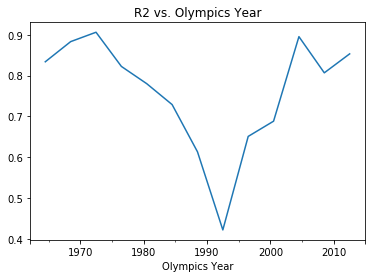

In [17]:
scores.set_index('Olympics Year')['r2'].plot(title='R2 vs. Olympics Year')

### Plotting the binned scores


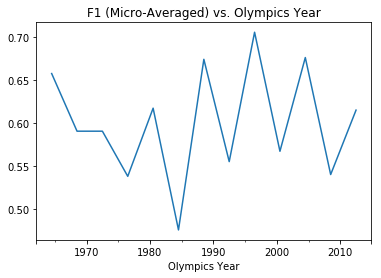

In [18]:
binned_scores.set_index('Olympics Year')['f1_micro'].plot(title='F1 (Micro-Averaged) vs. Olympics Year')

### Plotting the binary scores

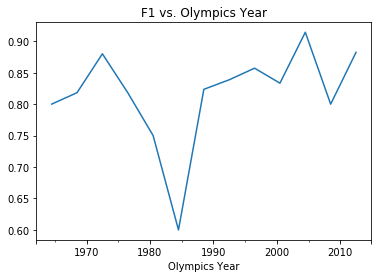

In [19]:
binary_scores.set_index('Olympics Year')['f1'].plot(title='F1 vs. Olympics Year')

Notice how the binned problem is harder in different years than the regression problem. 1984 is a terrible year for the binned predictor, while 1992 is much worse for the regression predictor. The binary score is on the whole smoother over time, but still has a major hiccup in 1984.

In [20]:
binary_scores

,f1,roc_auc,Olympics Year
0,0.800000,0.939103,1964-06-29
1,0.818182,0.882812,1968-06-29
2,0.880000,0.976427,1972-06-29
3,0.818182,0.966667,1976-06-29
4,0.750000,0.941667,1980-06-29
5,0.600000,0.960459,1984-06-29
6,0.823529,0.967980,1988-06-29
7,0.838710,0.931327,1992-06-29
8,0.857143,0.928034,1996-06-29
9,0.833333,0.940476,2000-06-29


## Confusion Matrices

The confusion matrix is a good way to quickly see well a model is predicting binary outcomes. For an intro to what these are, see Scikit-Learn's [User Guide](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix).
Let's plot the confusion matrix for 1984 (a hard-to-predict year) and 2004 (an easy-to-predict year) using this example from Scikit-Learn [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

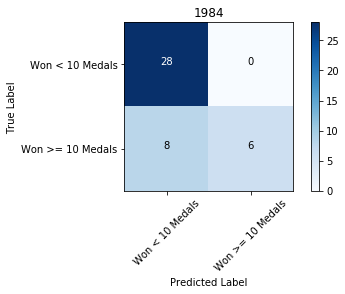

In [21]:
# 1984 = 5th split
split, year = 5, '1984'
train, test = splitter.split(X, y_binary)[split]
pipeline.fit(X[train], y_binary[train])
y_pred = pipeline.predict(X[test])
cm = confusion_matrix(y_binary[test], y_pred)
plot_confusion_matrix(cm, ['Won < 10 Medals', 'Won >= 10 Medals'], title=year)

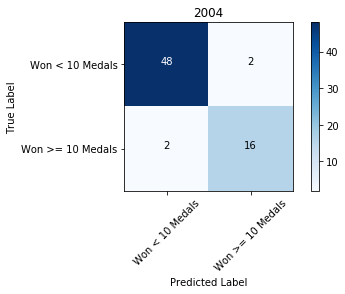

In [22]:
# 2004 = 10th split
split, year = 10, '2004'
train, test = splitter.split(X, y_binary)[split]
pipeline.fit(X[train], y_binary[train])
y_pred = pipeline.predict(X[test])
cm = confusion_matrix(y_binary[test], y_pred)
plot_confusion_matrix(cm, ['Won < 10 Medals', 'Won >= 10 Medals'], title=year)

In 1984, we underestimated how many medals 8 countries scored, while in 2004, we underestimated only 2 countres and overestimated 2. As we'll see later, this is probably due to the boycott in 1984 by Soviet Bloc countries, leading to higher medals scored by the democratic nations like the USA.

## Comparison to baseline

We do significantly better on all problem types and all metrics than our non-machine learning baseline, which only achieves 0.79 AUC compared to the 0.94 we get here.

## How to improve?

For particular years and countries this is a very hard problem for which additional data is needed to make better predictions. We will examine this issue in a future notebook. The problem arises from the fact that many outside factors contribute to weird outcomes at the Olympics which don't exist in our dataset. Boycotts and steroid scandals are a key example. Using only this current dataset detailing each medal that was won, there is no way for us to know which countries refrained from competing or which were disqualified after the fact.

However, our interpretable features now provide us with a way to examine which hidden factors are predictive of the outcome.

# Step 4: Refinement

This utility function grabs the Scikit-Learn Random Forest's built in feature importances, sorts them, and groups them by time split. These refer to how much weight the algorithm placed on each feature in order to predict the labels. Using lots of estimators in the Random Forest allows it to distinguish between the quality of different features.

We'll print out the top 10 highest weighted features for each Olympics since 1960.

In [23]:
rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])

feature_imps_over_time = get_feature_importances(pipeline,
                                                 feature_matrix_encoded,
                                                 binary_labels,
                                                 splitter,
                                                 n=400)

In [24]:
for test_year in [1964, 2012]:
    print "Test year: %s" % test_year
    test_date = pd.Timestamp('6/29/{}'.format(test_year))
    display(feature_imps_over_time[test_date].iloc[:10].reset_index(drop=True))

Test year: 1964


,Feature,Importance
0,MEAN(countries_at_olympic_games.SKEW(medals_wo...,0.012329
1,MEAN(countries_at_olympic_games.NUM_UNIQUE(med...,0.010616
2,MEAN(countries_at_olympic_games.COUNT(medals_w...,0.010410
3,MEAN(countries_at_olympic_games.SUM(medals_won...,0.009924
4,MAX(countries_at_olympic_games.SKEW(medals_won...,0.009621
5,MAX(countries_at_olympic_games.SKEW(medals_won...,0.009244
6,COUNT(medals_won WHERE Medal = Gold),0.008951
7,MEAN(countries_at_olympic_games.COUNT(medals_w...,0.008815
8,Country = United States,0.008600
9,Country = France,0.008501


Test year: 2012


,Feature,Importance
0,MEAN(countries_at_olympic_games.SKEW(medals_wo...,0.013470
1,MEAN(countries_at_olympic_games.NUM_UNIQUE(med...,0.012427
2,MAX(countries_at_olympic_games.SKEW(medals_won...,0.012418
3,MEAN(countries_at_olympic_games.NUM_UNIQUE(med...,0.012271
4,MEAN(countries_at_olympic_games.COUNT(medals_w...,0.011655
5,MEAN(countries_at_olympic_games.SKEW(medals_wo...,0.010516
6,MEAN(countries_at_olympic_games.SUM(medals_won...,0.010172
7,MEAN(countries_at_olympic_games.COUNT(medals_w...,0.009925
8,MEAN(countries_at_olympic_games.NUM_UNIQUE(med...,0.009803
9,MEAN(countries_at_olympic_games.COUNT(medals_w...,0.009706


We see the statistical Skew function is heavily represented. Skew is a useful property of statistical distributions that tells us how short and fat or long and skinny the extreme values of the set of numbers are.

We will examine particular features and what they mean in more depth later on.

## Supervised Feature Selection

One interesting workflow that Featuretools allows is the ability to select a subset of features from an exhaustive list based on which ones the RandomForest placed a lot of weight on.

To do this, let's rerun the computation using just the top 400 features

In [25]:
top400 = feature_imps_over_time[pd.Timestamp('6/29/2012')]['Feature'].tolist()
important_feature_matrix = feature_matrix_encoded[top400]

rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binary_scores = fit_and_score(important_feature_matrix.values, y_binary, splitter, pipeline, _type='classification')
show_score(binary_scores, 'f1')

  f1 mean score:  0.82 +/- 0.08


In [26]:
binary_scores

,f1,roc_auc,Olympics Year
0,0.800000,0.916667,1964-06-29
1,0.818182,0.902344,1968-06-29
2,0.880000,0.977667,1972-06-29
3,0.818182,0.970370,1976-06-29
4,0.750000,0.962500,1980-06-29
5,0.600000,0.927296,1984-06-29
6,0.823529,0.971675,1988-06-29
7,0.838710,0.931327,1992-06-29
8,0.857143,0.930183,1996-06-29
9,0.864865,0.924603,2000-06-29


## Comparison to full feature set

We do approximately the same as our original model. What's more interesting is that we now have a smaller set of highly explainable features. We can reduce this feature set even more without a huge drop in accuracy. Here it is with 100 features.

In [27]:
important_feature_matrix = important_feature_matrix[top400[:100]]

rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binary_scores = fit_and_score(important_feature_matrix.values, y_binary, splitter, pipeline, _type='classification')
show_score(binary_scores, 'f1')

  f1 mean score:  0.82 +/- 0.08


## Smaller set of important features

Now let's take a closer look at the highest weighted features

In [28]:
feature_imps_over_time = get_feature_importances(pipeline,
                                                 important_feature_matrix,
                                                 binary_labels,
                                                 splitter,
                                                 n=50)
pd.set_option('display.max_colwidth', 100)
for test_year in [1964, 2012]:
    print "Test year: %s" % test_year
    test_date = pd.Timestamp('6/29/{}'.format(test_year))
    display(feature_imps_over_time[test_date].iloc[:10].reset_index(drop=True))
pd.set_option('display.max_colwidth', 50)

Test year: 1964


,Feature,Importance
0,MEAN(countries_at_olympic_games.COUNT(medals_won WHERE Medal = Gold)),0.047981
1,MEAN(countries_at_olympic_games.SUM(medals_won.NUM_UNIQUE(medaling_athletes.athletes.Gender))),0.033700
2,COUNT(medaling_athletes),0.029114
3,MAX(countries_at_olympic_games.countries.mean_num_medals),0.025996
4,MEAN(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.athletes.Gender))),0.025273
5,MEAN(countries_at_olympic_games.NUM_UNIQUE(medals_won.disciplines.MODE(medals_won.Event))),0.024172
6,MEAN(countries_at_olympic_games.SUM(medals_won.disciplines.NUM_UNIQUE(medals_won.Medal))),0.022265
7,COUNT(medals_won WHERE Medal = Gold),0.022099
8,COUNT(medals_won),0.019102
9,MEAN(countries_at_olympic_games.NUM_UNIQUE(medals_won.Event)),0.018379


Test year: 2012


,Feature,Importance
0,MEAN(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.Athlete))),0.063290
1,MEAN(countries_at_olympic_games.SKEW(medals_won.COUNT(medaling_athletes))),0.059640
2,MEAN(countries_at_olympic_games.COUNT(medals_won WHERE Medal = Gold)),0.039226
3,MEAN(countries_at_olympic_games.COUNT(medals_won WHERE Medal = Silver)),0.029416
4,MAX(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.Athlete))),0.027165
5,MEAN(countries_at_olympic_games.SUM(medals_won.NUM_UNIQUE(medaling_athletes.athletes.Gender))),0.024432
6,MEAN(countries_at_olympic_games.NUM_UNIQUE(medals_won.MODE(medaling_athletes.Athlete))),0.023940
7,MEAN(countries_at_olympic_games.NUM_UNIQUE(medals_won.Event)),0.023752
8,MEAN(countries_at_olympic_games.SUM(medals_won.disciplines.NUM_UNIQUE(medals_won.Event))),0.023173
9,"TREND(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.Athlete)), Year)",0.019542


The important features make a lot of sense. The most important feature in 1964 and second most in 2012 is `MEAN(countries_at_olympic_games.COUNT(medals_won WHERE Medal = Gold))`. Let's parse this. The best way to read this is from the inside out. We see `COUNT(medals_won WHERE Medal = Gold` &mdash; This is the number of gold medals for each country at each individual Olympics. We then take the mean over all previous Olympics of this quantity, for each country. Putting it all together, it is a country's average gold medal count.

The best feature in 2012 is a skew feature. It's `MEAN(countries_at_olympic_games.SKEW(medals_won.COUNT(medaling_athletes)))`. Again, start from the inside. `medals_won.COUNT(medaling_athletes)` counts the number of athletes for each medal, which is relevant for a team sport like basketball where many athletes can win the same medal. Then we take the skew of the distribution of those values across all the medals a country won in a particular Olympics, and average across all previous Olympics. This skew quantity is a measure of how weird the distribution looks compared to a normal Bell-curve distribution, and so captures information about how many of a country's medals are won in team sports. 

Finally, an easier one to parse is `COUNT(medaling_athletes)`. It's just a count of all the athletes that have won medals for a country in the past.

## Why were some years difficult to predict?
Specifically, the years between 1970 and 1992 showed high variability in scores.

The Olympics in the 1980s were marred by controversies. Summarizing the
[Wikipedia article](https://en.wikipedia.org/wiki/List_of_Olympic_Games_scandals_and_controversies):
1. Rule changes
   - This is the period that the IOC gradually started allowing professional
   athletes
2. Geopolitics
   - Widespread boycotts due to the Cold War
   - Montreal 1976: 22 African nations boycotted (to protest New Zealand's
   rugby team's tour of South Africa during Apartheid). China and Taiwan both
   boycotted. Fewest number of countries (92) participating since 1960.
   - Moscow 1980: US boycotts because of Soviet invasion of Afghanistan.
      Even fewer number of countries (80) than 1976
   - Los Angeles 1984: Soviet Union and 15 Eastern Bloc nations boycott
   because of "safety concerns". (However, a record 140 National Olympic
   Committees took part)
      Even fewer number of countries (80) than 1976
3. Performance-enhancing Drugs
   - late 1970s and especially 1980s ushered in the era of steroids
   - quote from 1989 Australian study "There is hardly a medal winner at the
   Moscow Games, certainly not a gold medal winner, who is not on one sort of
   drug or another: usually several kinds. The Moscow Games might as well have
   been called the Chemists' Games." See the wiki
   [page](https://en.wikipedia.org/wiki/Olympic_Games#Use_of_performance-enhancing_drugs), citation 183.
4. Gender discrimination
   - Many countries didn't send women until the late 1990s

## Let's make a prediction about the 2016 Olympics

We've trained models to predict the highest medaling countries in past Olympic Games, so we might as well use those models to predict who will receive the most medals in the next Olympics. This dataset came out before 2016, so we can compare to what actually happened. Unfortunately, the way our model is set up we would have to add in the 2016 data to make predictions about 2020 (I'll leave that up to you to try out yourself).

Progress: 100%|██████████| 1/1 [00:31<00:00, 31.97s/cutoff time]


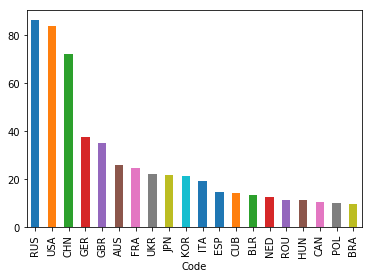

In [29]:
# Train on all data
reg_pipeline.fit(important_feature_matrix, y)

# Get the top feature objects to compute
important_features = {f.get_name(): f for f in features_encoded
                      if f.get_name() in important_feature_matrix.columns}.values()
# Compute feature matrix on all data (no cutoff time)
# Leave cutoff_date blank to use the current time
df = es['countries_at_olympic_games'].df
countries_2012 = df.loc[df['Year'] == pd.Timestamp('2012-06-30'), 'Country']
latest_fm = ft.calculate_feature_matrix(features=important_features,
                                        instance_ids=countries_2012,
                                        cutoff_time=None,
                                        verbose=True)
# Make sure order is correct
latest_fm = latest_fm[important_feature_matrix.columns]

predictions = reg_pipeline.predict(latest_fm)
predictions_by_country = pd.Series(predictions, index=latest_fm.index)
predictions_by_country.sort_values(ascending=False, inplace=True)
predictions_by_country.head(20).plot(kind='bar')

The actual medal count is available [here](https://en.wikipedia.org/wiki/2016_Summer_Olympics_medal_table).
I took the first 20 to plot:

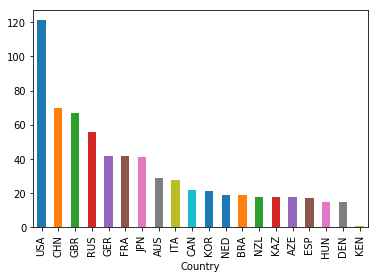

In [30]:
actual_2016 = pd.DataFrame.from_records([('USA', 121),
('CHN', 70) ,
('GBR', 67) ,
('RUS', 56) ,
('GER', 42) ,
('FRA', 42) ,
('JPN', 41) ,
('AUS', 29) ,
('ITA', 28) ,
('CAN', 22) ,
('KOR', 21) ,
('NED', 19) ,
('BRA', 19) ,
('NZL', 18) ,
('KAZ', 18) ,
('AZE', 18) ,
('ESP', 17) ,
('HUN', 15) ,
('DEN', 15) ,
('KEN', 1)], columns=['Country', 'Medals']).set_index(['Country'])['Medals']

actual_2016.plot(kind='bar')

#### Side by side comparison

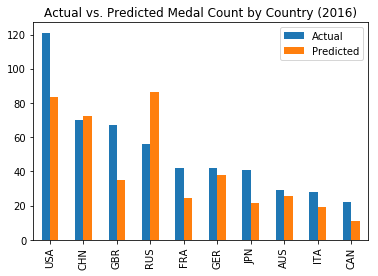

In [31]:
(pd.DataFrame({'Predicted': predictions_by_country.head(100), 'Actual': actual_2016.head(100)})
   .sort_values(['Actual'],ascending=False).head(10)
   .plot(kind='bar', title='Actual vs. Predicted Medal Count by Country (2016)'))

Looks like we overestimated Russia and underestimated Great Britain and China!

However- recall that in this past Olympics Russia was implicated in a major state-sponsored doping scandal. This resulted in the disqualification of essentially the entire track & field team. So Russia would otherwise probably have score many more medals.

## A fun prediction
Our data includes all the countries that have ever medaled in any Olympics. There's nothing stopping us from generating predictions for defunct countries. Let's see what happens if we predict the number of medals won in 2016 for every historical country.

Progress: 100%|██████████| 1/1 [00:42<00:00, 42.04s/cutoff time]


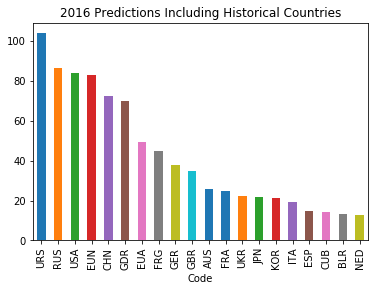

In [32]:
# Leave instance_ids blank to use all
latest_fm = ft.calculate_feature_matrix(features=important_features,
                                        cutoff_time=None,
                                        verbose=True)
# Make sure order is correct
latest_fm = latest_fm[important_feature_matrix.columns]

predictions = reg_pipeline.predict(latest_fm)
predictions_by_country_all = pd.Series(predictions, index=latest_fm.index)
predictions_by_country_all.sort_values(ascending=False, inplace=True)
predictions_by_country_all.head(20).plot(kind='bar', title='2016 Predictions Including Historical Countries')

Our model thinks that if the former Soviet Union were alive today it would win it all, the unified post-Soviet breakup team (EUN) would come in 3rd, and both East Germany (GDR) and West Germany (FRG) would come out ahead of modern-day Germany (GER).

<p>
    <img src="https://www.featurelabs.com/img/logo.png" alt="Featuretools" />
</p>


Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact.html).